The center of the enclosing circle is at coordinates: (1133, 1133)
X (mm)	Y (mm)	d (mm)	2θ (degrees)	Intensity
[[0.00000000e+00 0.00000000e+00 2.40310255e+02 6.74064024e+01
  6.37500000e+01]
 [0.00000000e+00 1.49977944e-01 2.40204228e+02 6.73974323e+01
  6.37500000e+01]
 [0.00000000e+00 2.99955889e-01 2.40098248e+02 6.73884594e+01
  6.37500000e+01]
 ...
 [3.39850022e+02 3.39550066e+02 2.40098248e+02 6.73884594e+01
  6.37500000e+01]
 [3.39850022e+02 3.39700044e+02 2.40204228e+02 6.73974323e+01
  6.37500000e+01]
 [3.39850022e+02 3.39850022e+02 2.40310255e+02 6.74064024e+01
  6.37500000e+01]]
X (mm)	Y (mm)	d (mm)	2θ (degrees)	Intensity
[[0.00000000e+00 0.00000000e+00 2.40310255e+02 6.74064024e+01
  6.37500000e+01]
 [0.00000000e+00 1.49977944e-01 2.40204228e+02 6.73974323e+01
  6.37500000e+01]
 [0.00000000e+00 2.99955889e-01 2.40098248e+02 6.73884594e+01
  6.37500000e+01]
 ...
 [3.39850022e+02 3.39550066e+02 2.40098248e+02 6.73884594e+01
  6.37500000e+01]
 [3.39850022e+02 3.39700044e+02 2.

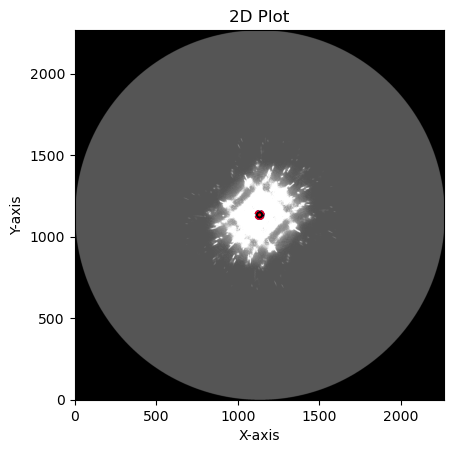

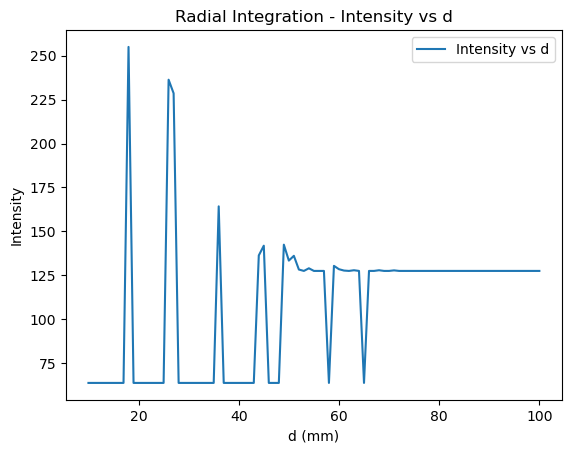

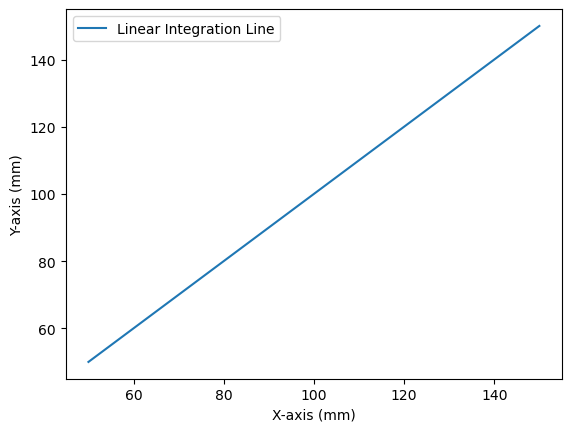

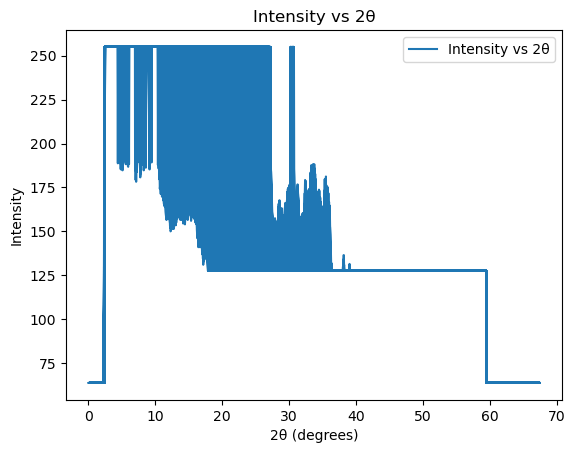

In [8]:
## Image Plate Diffraction System ##

## Image Analysis Integration (Version 1.4) ##

## Empa, Center for X-ray Analytics, D.Sapalidis, St. Gallen, Switzerland, 22.12.2023 ##

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image


class ImageClicker:
    def __init__(self, image_path, outer_radius_mm):
        self.image = np.array(Image.open(image_path))
        self.grayscale_image = np.mean(self.image, axis=2)
        self.fig, self.ax = plt.subplots()
        self.im = self.ax.imshow(self.grayscale_image, cmap='gray', origin='lower')
        self.coords = []

        self.ax.set_title('2D Plot')
        self.ax.set_xlabel('X-axis')
        self.ax.set_ylabel('Y-axis')
        
        self.outer_radius_mm = outer_radius_mm

        # Find the enclosing circle around points with minimum intensity
        self.center, radius = self.find_center_and_enclosing_circle()
        print(f'The center of the enclosing circle is at coordinates: ({self.center[0]}, {self.center[1]})')

        # Display the center and circles on the plot
        self.draw_circle(self.center[0], self.center[1], radius)

        # Draw the red disk on the plot
        red_disk_patch = patches.Circle((self.center[0], self.center[1]), radius, color='red', fill=False, linestyle='dashed')
        self.ax.add_patch(red_disk_patch)

    def find_center_and_enclosing_circle(self):
        # Define the region of interest (ROI)
        x_max, y_max = self.grayscale_image.shape
        roi_x_start, roi_x_end = x_max // 4, int(x_max / 1.5)
        roi_y_start, roi_y_end = y_max // 4, int(y_max / 1.5)

        # Extract the ROI from the grayscale image
        roi = self.grayscale_image[roi_x_start:roi_x_end, roi_y_start:roi_y_end]

        # Find the coordinates of points with minimum intensity in the ROI
        min_intensity_coords = np.argwhere(roi == np.min(roi))

        # Shift the coordinates back to the original image coordinates
        min_intensity_coords[:, 0] += roi_x_start
        min_intensity_coords[:, 1] += roi_y_start

        # Find the enclosing circle
        _, radius = cv2.minEnclosingCircle(min_intensity_coords.astype(np.float32))
        return tuple(map(int, min_intensity_coords.mean(axis=0))), int(radius)


    def draw_circle(self, center_x, center_y, radius):
        # Display the center and circle on the plot
        center_marker = plt.Circle((center_x, center_y), 5, color='red', fill=True)
        disk_patch = patches.Circle((center_x, center_y), radius, color='blue', fill=False, linestyle='dashed')

        self.ax.add_patch(center_marker)
        self.ax.add_patch(disk_patch)

class ImageProcessor:
    def __init__(self, clicker, wavelength, sample_detector_distance):
        self.clicker = clicker
        self.wavelength = wavelength
        self.sample_detector_distance = sample_detector_distance
        self.process_image()

    def process_image(self):
        mm_per_pixel_x = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[1]
        mm_per_pixel_y = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[0]

        mm_intensity_array = np.zeros_like(self.clicker.grayscale_image, dtype=float)
        mm_d_theta_intensity_array = []

        for x, row in enumerate(self.clicker.grayscale_image):
            for y, intensity in enumerate(row):
                radius = np.sqrt((x - self.clicker.center[0]) ** 2 + (y - self.clicker.center[1]) ** 2)
                mm_x = x * mm_per_pixel_x
                mm_y = y * mm_per_pixel_y

                # d distance calculation from center
                d = radius * (mm_per_pixel_x + mm_per_pixel_y)/2

                # 2 theta calculation
                theta = np.degrees(np.arctan(d / self.sample_detector_distance))

                # Save the data
                mm_d_theta_intensity_array.append([mm_x, mm_y, d, theta, intensity])

        
        mm_d_theta_intensity_array = np.array(mm_d_theta_intensity_array)

        # Print the matrix
        print("X (mm)\tY (mm)\td (mm)\t2θ (degrees)\tIntensity")
        print(mm_d_theta_intensity_array)

class Integration:
    def __init__(self, clicker, sample_detector_distance):
        self.clicker = clicker
        self.sample_detector_distance = sample_detector_distance
        self.mm_d_theta_intensity_array = None  

    def process_image(self):
        mm_per_pixel_x = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[1]
        mm_per_pixel_y = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[0]

        mm_d_theta_intensity_array = []

        for x, row in enumerate(self.clicker.grayscale_image):
            for y, intensity in enumerate(row):
                radius = np.sqrt((x - self.clicker.center[0]) ** 2 + (y - self.clicker.center[1]) ** 2)
                mm_x = x * mm_per_pixel_x
                mm_y = y * mm_per_pixel_y

                # d distance calculation from center
                d = radius * (mm_per_pixel_x + mm_per_pixel_y) / 2

                # 2 theta calculation
                theta = np.degrees(np.arctan(d / self.sample_detector_distance))

                # Save the data
                mm_d_theta_intensity_array.append([mm_x, mm_y, d, theta, intensity])

        self.mm_d_theta_intensity_array = np.array(mm_d_theta_intensity_array)

        # Print the matrix
        print("X (mm)\tY (mm)\td (mm)\t2θ (degrees)\tIntensity")
        print(self.mm_d_theta_intensity_array)

    def radial_integration(self, r_min, r_max):
        if self.mm_d_theta_intensity_array is None:
            self.process_image()

        average_intensities = []

        for d in range(r_min, r_max + 1):
            # Επιλογή των σημείων που αντιστοιχούν στη συγκεκριμένη ακτίνα r
            points_for_radius = self.mm_d_theta_intensity_array[np.isclose(self.mm_d_theta_intensity_array[:, 2], d)]

            if len(points_for_radius) > 0:
                # Υπολογισμός του μέσου όρου της έντασης
                average_intensity = np.mean(points_for_radius[:, 4])
                average_intensities.append([d, average_intensity])
            else:
                # Εάν δεν υπάρχουν στοιχεία σε αυτήν την ακτίνα, καταχωρήστε την ένταση του πρώτου στοιχείου (αν υπάρχει)
                if len(self.mm_d_theta_intensity_array) > 0:
                    average_intensities.append([d, self.mm_d_theta_intensity_array[0, 4]])

        average_intensities = np.array(average_intensities)

        # Σχεδίαση του γραφήματος μέσης έντασης ως συνάρτηση της ακτίνας r
        plt.figure()
        plt.plot(average_intensities[:, 0], average_intensities[:, 1], label='Intensity vs d')
        plt.title('Radial Integration - Intensity vs d')
        plt.xlabel('d (mm)')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()

    def linear_integration(self, start_point, end_point):
        if self.mm_d_theta_intensity_array is None:
            self.process_image()

        # Υλοποίηση της γραμμικής ολοκλήρωσης
        mm_per_pixel_x = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[1]
        mm_per_pixel_y = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[0]

        # Υπολογισμός των αντίστοιχων σημείων του ευθύγραμμου τμήματος στο διάγραμμα
        start_x, start_y = start_point[0] / mm_per_pixel_x, start_point[1] / mm_per_pixel_y
        end_x, end_y = end_point[0] / mm_per_pixel_x, end_point[1] / mm_per_pixel_y

        # Δημιουργία της ευθείας
        line_x, line_y = np.linspace(start_x, end_x, 100), np.linspace(start_y, end_y, 100)

        # Υπολογισμός των αντίστοιχων συντεταγμένων στο διάγραμμα
        mm_line_x, mm_line_y = line_x * mm_per_pixel_x, line_y * mm_per_pixel_y

        # Σχεδίαση της ευθείας
        plt.figure()
        plt.plot(mm_line_x, mm_line_y, label='Linear Integration Line')
        plt.xlabel('X-axis (mm)')
        plt.ylabel('Y-axis (mm)')
        plt.legend()
        plt.show()

    def plot_intensity_vs_theta(self):
        if self.mm_d_theta_intensity_array is None:
            self.process_image()

        # Σχεδίαση του γραφήματος έντασης ως συνάρτηση της γωνίας 2θ
        plt.figure()
        plt.plot(self.mm_d_theta_intensity_array[:, 3], self.mm_d_theta_intensity_array[:, 4], label='Intensity vs 2θ')
        plt.title('Intensity vs 2θ')
        plt.xlabel('2θ (degrees)')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()


if __name__ == "__main__":
    
    # User's input - Type the parameters of the experiment and the path of the image
    main_image_path = 'C:/Users/Dimitris/Desktop/IPDS Images Results/DCSQI_annealed_40mm_240min_om0_ph10rpm_201223.tif'
    outer_radius_mm = 170
    wavelength = 0.71  # σε Ångströms
    sample_detector_distance = 100  # σε mm

    clicker = ImageClicker(main_image_path, outer_radius_mm)
    processor = ImageProcessor(clicker, wavelength, sample_detector_distance)

    # Χρήση της νέας λειτουργίας ακτινικής ολοκλήρωσης
    integration = Integration(clicker, sample_detector_distance)
    integration.radial_integration(r_min=10, r_max=100)

    # Χρήση της νέας λειτουργίας γραμμικής ολοκλήρωσης
    integration.linear_integration(start_point=[50, 50], end_point=[150, 150])

    # Σχεδίαση του γραφήματος έντασης ως συνάρτηση της γωνίας 2θ
    integration.plot_intensity_vs_theta()
